# CS436 PA1 Image Warping

In [0]:
Run the following cell, in order to mount your drive with this notebook.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

This might take a few seconds. If any library is missing, make sure to install it in your environment, using anaconda in for library installation is usually easier

In [0]:
import matplotlib
import imageio
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import image as mpimg
from matplotlib.pyplot import figure
%matplotlib inline

import seaborn as sns
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

import cv2
# import time

# 1. Image Warping

In this section, <b>you are not allowed to use any OpenCV functions.</b> OpenCV comes in the next section

## Task 1.1 - Part A (Projective Transformations)



In this section you will be creating a function `warpPerspective(img,M,(cols,rows))`. 
The function performs a projective transformation on an image and returns a new image variable
    
    This function has the following arguments:
        img: original image variable. This can be a black and white or a color image
        M: a 3x3 projective transformation matrix
        cols: the columns of the output image
        rows: the rows of the output matrix        

The function can transform a small image to a larger image. While doing so, the new image must not have any fringes or emply pixels, you can fill those pixels by taking the value of the nearest neigbouring pixel. The pixels outside of an image may be set to black for now. You may change the arguments of the function if you want to add additional features

In [0]:
def isValidCoord(coord, x, y):
  if 0 <= coord[0] < x and 0 <= coord[1] < y:
    return True
  return False

def avgInterp(pixelQuad, img):
  x0, x1, y0, y1 = pixelQuad
  h, w, n = img.shape
  avg_pixel, count = [0.0, 0.0, 0.0, 0.0], 0
  
  #tl
  if isValidCoord((x0, y0), h, w): 
    avg_pixel = np.add(avg_pixel, img[x0][y0])
    count = count + 1
  #tr
  if isValidCoord((x1, y0), h, w): 
    avg_pixel = np.add(avg_pixel, img[x1][y0])
    count = count + 1
  #bl
  if isValidCoord((x0, y1), h, w): 
    avg_pixel = np.add(avg_pixel, img[x0][y1])
    count = count + 1
  #br
  if isValidCoord((x1, y1), h, w): 
    avg_pixel = np.add(avg_pixel, img[x1][y1])
    count = count + 1

  if count > 0:
    avg_pixel = (np.divide(avg_pixel, count)).astype(float)
    return (avg_pixel, True)
  else:
    return ([], False)


def avgInterp2(pixelQuad, img):
  x0, x1, y0, y1 = pixelQuad
  h, w, n = img.shape
  avg_pixel, count = [0, 0, 0], 0
  
  #tl
  if isValidCoord((x0, y0), h, w): 
    avg_pixel = np.add(avg_pixel, img[x0][y0])
    count = count + 1
  #tr
  if isValidCoord((x1, y0), h, w): 
    avg_pixel = np.add(avg_pixel, img[x1][y0])
    count = count + 1
  #bl
  if isValidCoord((x0, y1), h, w): 
    avg_pixel = np.add(avg_pixel, img[x0][y1])
    count = count + 1
  #br
  if isValidCoord((x1, y1), h, w): 
    avg_pixel = np.add(avg_pixel, img[x1][y1])
    count = count + 1

  if count > 0:
    avg_pixel = (np.divide(avg_pixel, count)).astype(np.uint8)
    return (avg_pixel, True)
  else:
    return ([], False)
  
def coordPick(coordQuad, i, j):
  return (coordQuad[i], coordQuad[j])

def transformCoord(i, j, H):
  # using the homography equations with all 9 variables for projective matrix from slides
  # ipFloat = (H[0][0]*i + H[0][1]*j + H[0][2]*1)/(H[2][0]*i + H[2][1]*j + H[2][2]*1)
  # jpFloat = (H[1][0]*i + H[1][1]*j + H[1][2]*1)/(H[2][0]*i + H[2][1]*j + H[2][2]*1)    
  ipFloat, jpFloat, h = np.matmul(H, [i, j, 1]) # VIA Homogenous to nonhomog conversion after mult, iprime float, jprime float
  ipFloat = ipFloat / h
  jpFloat = jpFloat / h
  return [int(np.floor(ipFloat)), int(np.ceil(ipFloat)), int(np.floor(jpFloat)), int(np.ceil(jpFloat))]

def toPNG(jpg):
  h, w, n = jpg.shape
  png = np.multiply(jpg, 1/255.0) # rgb values scaled between 0.0 to 1.0 floats from 0-255 uint8s
  l = np.ones((h, w, 1), dtype=float)
  png = np.concatenate((png, l), axis=2) # concatenate the two 3D arrays on the 3rd dimension
  # 1.0's attached
  return png

def bounding_box(h, w, M):
  bounding_corners = np.array([coordPick(transformCoord(0, 0, M), 0, 2), coordPick(transformCoord(0, w-1, M), 1, 2),
                              coordPick(transformCoord(h-1, 0, M), 0, 3), coordPick(transformCoord(h-1, w-1, M), 1, 3)])
  xmin, ymin = np.amin(bounding_corners, axis=0)
  xmax, ymax = np.amax(bounding_corners, axis=0)
  return max(xmin, 0), max(ymin, 0), min(xmax, rows-1), min(ymax, cols-1)
  
def warpPerspective12(img,M,dsize):
  #input = img/src, outut image = dst with size dsize
  cols, rows = dsize
  dst = np.zeros((rows,cols,3), dtype=np.uint8)
  # avg interpolation, and pixel fetch inverse, with minimum bounding box optimization
  h,w,n = img.shape
  
  Minverse = np.linalg.inv(M) 
  xmin, ymin, xmax, ymax = bounding_box(h, w, M)
  
  for i in range(xmin, xmax+1):
    for j in range(ymin, ymax+1):
      originalCoordQuad = transformCoord(i, j, Minverse)
      # fc = coordPick(originalCoordQuad, 0, 2) #fc =floorCoords
      # if isValidCoord(fc, h, w):
      #   dst[i][j] = img[fc[0]][fc[1]].copy() 
      averagedPixelPack = avgInterp2(originalCoordQuad, img)
      if averagedPixelPack[1]:
        dst[i][j] = averagedPixelPack[0]
  
  return dst.astype(np.uint8)
  
def warpPerspective(img,M,dsize):
  if (img.dtype == np.uint8): # for RGBs only
    img = toPNG(img)
  
  #input = img/src, outut image = dst with size dsize
  cols, rows = dsize
  dst = np.zeros((rows,cols,4), dtype=float)
  #TODO
  # avg interpolation, and pixel fetch inverse, with minimum bounding box optimization
  h,w,n = img.shape
  
  Minverse = np.linalg.inv(M) 
  xmin, ymin, xmax, ymax = bounding_box(h, w, M)

  for i in range(xmin, xmax+1):
    for j in range(ymin, ymax+1):
      originalCoordQuad = transformCoord(i, j, Minverse)
      averagedPixelPack = avgInterp(originalCoordQuad, img)
      if averagedPixelPack[1]:
        dst[i][j] = averagedPixelPack[0]
  
  return dst.astype(float)

## Task 1.1 - Part B: Rotation



In this test case, we will be rotating a subsection of an image of a cat. We will convert `cat.jpg` to `cat_sol0_1.jpg`



We can utilize your newly made function for that with the following steps

1. Read the file `part1/cat.jpg`
2. Crop it to the portion that shows just the head
3. Input it to your function with your projective matrix
4. Display the output
5. You can adjust the row and col values such that the entirety of the output image is shown
    
The output should look similar to `part1/cat_sol0_1.jpg`. You can try coming up with a transformation on paper before using it. Affine transformations are a subset of projective transformations, so you can try starting from those

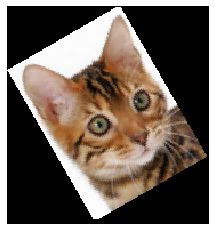

In [0]:


cat = np.array(mpimg.imread('part1/cat.jpg'))
cat.setflags(write=1)

# checked from output file given
cols = 177
rows = 191
cat_crop = cat[5:160, 85:200]
h, w, n = cat_crop.shape

#TODO
angle = np.radians(30) # 3x3 affine, homogenous (rotation, translation, scale)
tx, ty, sx, sy = 57, 1, rows/h-0.25*(rows/191), rows/h-0.25*(rows/191)
s, c = np.sin(angle), np.cos(angle)
M = np.array([[sx*c, -sx*s, sx*tx],
              [sy*s, sy*c, sy*ty],
              [0, 0, 1]])

cat_sol0_1 = warpPerspective12(cat_crop,M,(cols,rows))

plt.axis('off')
plt.imshow(cat_sol0_1)
plt.show()
saving_path = 'part1/cat_sol0_1_mine.jpg' # replace this with your path, where you want to save the picture
mpimg.imsave(saving_path, cat_sol0_1) # if saving rgb files, remove cmap 

# 2. Interpolation

At this point, you can predict that creating a large image from small image will not give us the best results, ie there will be a lot of empty pixel values. There are multiple ways to handle this, i.e. Bilinear Interpolation, Nearest, Bicubic etc. However, the method that we will be utilizing in this assignment is fairly simple. We will be replacing empty pixel values with the average of all pixel values around that pixel. Be careful, while handling the corner/side pixels of the image.



## Task 2.1


For this, we can augment your function `warpPerspective(img,M,(cols,rows))`.

1. Where you previously took the nearest neighbor to fill missing pixels, use the `Interpolation` algorithm. 
2. Input cols and rows values as 2000 and 2160
3. Use the same projective matrix
4. Display the output
    
the output should look similar to `part1/cat_sol1.jpg`.

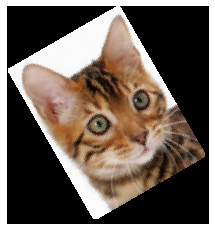

In [0]:
cols = 2000
rows = 2160
h,w,n = cat_crop.shape

angle = np.radians(30) # 3x3 affine, homogenous (rotation, translation, scale)
tx, ty, sx, sy = 57, 1, rows/h-0.25*(rows/191), rows/h-0.25*(rows/191)
M = np.array([[sx*np.cos(angle), -np.sin(angle)*sx, sx*tx],
              [sy*np.sin(angle), sy*np.cos(angle), sy*ty],
              [0, 0, 1]])

cat_sol1 = warpPerspective12(cat_crop, M, dsize=(cols,rows))
plt.axis('off')
plt.imshow(cat_sol1)
plt.show()
saving_path = 'part1/cat_sol1_mine.jpg'
mpimg.imsave(saving_path, cat_sol1)

# 3. Image Alpha Values



In this section we will be blending two images to create a third image. This process is important in applications such as VR, AR etc.

For this section, it is important to understand alpha values. Alpha values range between 0.0 and 1.0, and determine the transparency of a pixel. These are common in png files where they are stored alongside rgb as rgba. 

## Task 3.1

You must manipulate your `warpPerspective(img,M,(cols,rows))` function so that it returns values in the form of rgba. You can do this with the following steps: 

1. If the image has values in 8bit integers, convert your 0 - 255 color integer value range to 0.0 - 1.0 float. 
2. Append a forth pixel value for the alpha
3. It might be easier to create a seperate function that converts rgb to rgba with alpha values set to 1.0
4. Where you were previously setting the background to be black, also set the alpha to 0.0
    
The output from the previous test should look similar to `part1/cat_sol2.png`. you can explore the png file structure to get a better idea of the output. 




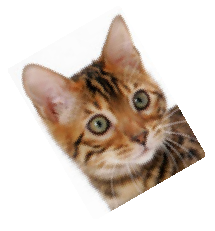

In [0]:
angle = np.radians(30) # 3x3 affine, homogenous (rotation, translation, scale)
tx, ty, sx, sy = 57, 1, rows/h-0.25*(rows/191), rows/h-0.25*(rows/191)
M = np.array([[sx*np.cos(angle), -np.sin(angle)*sx, sx*tx],
              [sy*np.sin(angle), sy*np.cos(angle), sy*ty],
              [0, 0, 1]])

cat_sol2 = warpPerspective(cat_crop, M, dsize=(cols,rows))
plt.axis('off')
plt.imshow(cat_sol2)
plt.show()
saving_path = 'part1/cat_sol2_mine.png'
mpimg.imsave(saving_path, cat_sol2)

# 4. Cricket Stadium



```
# This is formatted as code
```

In this part we will be adding an image of a cricket scoreboard to a cricket stadium.



In [0]:
# Your final output should look similar to the below given image i.e. stadium-sol5.jpg

## Task 4.1

For this task, you need to transform the given scoreboard image. Your output should look similar to `transformed-scoreboard.jpg`. You can try coming up with a transformation on paper before using it. Affine transformations are a subset of projective transformations, so you can try starting from those.

In [0]:
# transformed-scoreboard.jpg

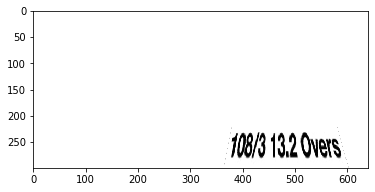

In [5]:
# start your code here
score = np.array(mpimg.imread('score.jpg'))
score.setflags(write=1)
h,w,n = score.shape
origin_rect = np.array([[0,h-1], [w-1, h-1],[w-1,0],[0,0]], np.float32)
transformed_rect = np.array([[363, 303], [603, 303], [580, 220], [380, 220]], np.float32)

# print(origin_rect, transformed_rect)
M = cv2.getPerspectiveTransform(src=origin_rect, dst=transformed_rect)
cols = 640
rows = 300

# transformed_score_rgb = cv2.warpPerspective(score,M,(cols,rows))
score = toPNG(score)
transformed_score = cv2.warpPerspective(score,M,(cols,rows))
plt.imshow(transformed_score)
plt.show()

## Task 4.2

After you have transformed the scorebaord you have to add it to the given stadium image. This can be done by copying pixel values from the transformed scoreboard image to the given stadium image. You need to figure out the appropriate conditions for copying the pixel values. 

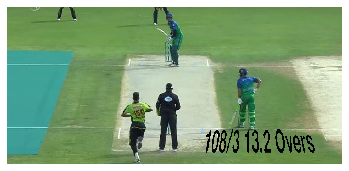

In [6]:
stadium = np.array(mpimg.imread('PSL-Stadium.jpg'))
stadium.setflags(write=1)
h,w,n = stadium.shape

stadium = toPNG(stadium)
for i in range(h):
  for j in range(w):
    scorePixel = transformed_score[i][j].copy()
    if scorePixel[3] == 1.0 and (scorePixel < 0.1).any():
      stadium[i][j] = scorePixel

plt.axis('off')
plt.imshow(stadium)
plt.show()

## Task 4.3

In certain situations, when we want to isolate a subject in an image, alpha masks are provided to us. Alpha masks describe the transparency of an image. These masks can be in any format ranging from jpg, png, bmp, gif,etc in our example we will be using jpg.

For this part we will reproduce the same solution but by using alpha mask this time. Below you are given an alpha mask for the transfomed scoreboard. Using this alpha mask you need to combine the two images together to produce the same output.

You can achieve the desired solution as follows:

Consider the transformed scoreboard image as the foreground image and the stadium image as the background image. At every pixel of the image, we need to combine the foreground image pixel value with the background image pixel value using the alpha mask.

 
\begin{align*}
T = \alpha*F+(1-\alpha)B
\end{align*}

1. Where T is target pixel value
2. F is the pixel value in the foreground image
3. B is the pixel value of the background image
4. Alpha is value of the alpha mask for the corresponding pixels

In [0]:
# score-mask.jpg

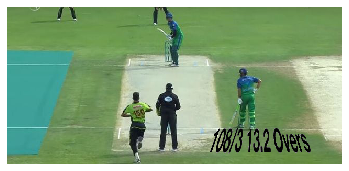

In [7]:
# start your code here
stadium = np.array(mpimg.imread('PSL-Stadium.jpg'))
stadium.setflags(write=1)
stadium = toPNG(stadium)

score_mask = np.array(mpimg.imread('score_mask.jpg'))
score_mask.setflags(write=1)
score_mask = toPNG(score_mask)

transformed_score = np.array(mpimg.imread('tscoreboard.jpg'))
transformed_score.setflags(write=1)
transformed_score = toPNG(transformed_score)

Timg = np.zeros((rows,cols,4), dtype=float)

for i in range(rows):
  for j in range(cols):
    F = np.array(transformed_score[i][j].copy())
    B = np.array(stadium[i][j].copy())
    A = np.array(score_mask[i][j].copy())[0]
    Timg[i][j] = A*F+(1-A)*B

plt.axis('off')
plt.imshow(Timg)
plt.show()

# 5. Solar System (CS5310, EE513 Only, Upto 10 marks bonus for CS436)

![alt Solar System demo](https://drive.google.com/uc?id=10xxjq46hha2HS0xjyaqM-iwgrMg01d6w)

In [0]:
height = width = 1500 # shape of canvas

## Task 5.1
In this task you will try to recreate the above gif by making use of all the previously implemented techniques.

Your first task is to import the image of planet earth and apply appropriate transformations to center it within the canvas. 

You are allowed to import opencv and make use of cv2.warpPerspective(sun,M,(width, height)) 



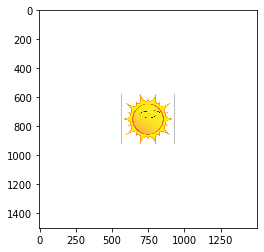

In [0]:
# Import sun.jpg and apply appropriate transformations to center the image
sun = np.array(mpimg.imread('sun.jpg'))
sun.setflags(write=1)
h,w,n = sun.shape

angle = np.radians(0) # 3x3 affine, homogenous (rotation, translation, scale)
tx, ty, sx, sy = (width-w)/2, (height-h)/2, 1, 1
M = np.array([[sx*np.cos(angle), -np.sin(angle)*sx, sx*tx],
              [sy*np.sin(angle), sy*np.cos(angle), sy*ty],
              [0, 0, 1]])

sun = toPNG(sun)
sun_ = cv2.warpPerspective(sun,M,(width, height)) 
plt.imshow(sun_)
plt.show()

Your result should look like (It does not matter whether the background is black or white)

Note: The resulting canvas has height and width of 1500px

![alt Sun Result](https://drive.google.com/uc?id=1IdYgql7RFwvXT1SxwuBRkW3AMKdZeexg)

## Task 5.2
In this part, you will carry out the same process for earth.jpg as well. Except, in this case the earth needs to be translated +400px on the y axis.

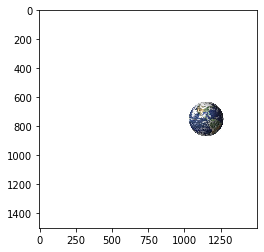

In [0]:
earth = np.array(mpimg.imread('earth.jpg'))
earth.setflags(write=1)
h,w,n = earth.shape

angle = np.radians(0)
tx, ty, sx, sy = (width-w)/2+400, (height-h)/2, 1, 1
M = np.array([[sx*np.cos(angle), -np.sin(angle)*sx, sx*tx],
              [sy*np.sin(angle), sy*np.cos(angle), sy*ty],
              [0, 0, 1]])

earth = toPNG(earth)
earth_ = cv2.warpPerspective(earth,M,(width, height)) 
plt.imshow(earth_)
plt.show()

Your final image should look something like this

![alt Result earth](https://drive.google.com/uc?id=16eFaOHVlhUKgHpw8ZVCwSvzagJcD_s8K)

## Task 5.3
You will now modify the above code to apply rotations to the earth as such it rotates along its own axis as well as around the sun. (This is same as the problem given to you in your written assignment 1)

Feel free to copy your code from task 5.2

In [0]:
def earth_func(earth,hour):
  h,w,n = earth.shape
  #earth -> this is the imported earth.jpg file in numpy array format
  #hour -> You will use this parameter to caculate the rotation of earth around the sun and along its own axis. For example,
  # if hour == 15 then rotation on its own axis will be 225 deg whilst rotations around the sun will be 0.61 deg
  # return val will be the transformed image of earth such as if hours == 0 the resulting image will be the same as task 5.2
  angle = np.radians((hour%24)*(360/24))
  s,c = np.sin(angle), np.cos(angle)
  B = np.array([[c,-s, 1],
                [s, c, 1],
                [0, 0, 1]])

  A = np.array([[1, 0, -w/2],
                [0, 1, -h/2],
                [0, 0, 1]])
  
  C = np.array([[1, 0, w/2+(width-w)/2],
                [0, 1, 0],
                [0, 0, 1]])
  
  angle = np.radians((hour%(365*24))*(360/(24*365)))
  s,c = np.sin(angle), np.cos(angle)
  D = np.array([[c,-s, 1],
                [s, c, 1],
                [0, 0, 1]])
  
  E = np.array([[1, 0, (width-w)/2],
                [0, 1, (height-h)/2],
                [0, 0, 1]])
  
  # earth = toPNG(earth)
  T = np.matmul(B,A)
  T = np.matmul(C, T)
  T = np.matmul(D, T)
  T = np.matmul(E, T)
  earth_ =  cv2.warpPerspective(earth,T,(width, height)) 
  return earth_

In [0]:
earths = []
for x in range(30):
  earths.append(earth_func(earth,x*10))

# for e in earths:
#   plt.axis('off')
#   plt.imshow(e)
#   plt.show()

## Task 5.4
You will now blend all three images to compose a single image. Feel free to make use of the canvas below.

You will have to traverse every element of the list (earths) and blend them with the transformed sun image created in task 5.1. After doing this, you will get an array of images in the end with each having a sun and a earth in them. Store this array in the variable final and run the code gif builder code in the end

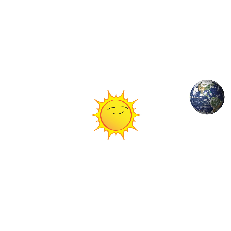

In [0]:
# Code for canvas
final = []
for e in earths:
  canvas = np.array([1.0]*4*width*height, dtype=float)
  canvas.resize((width,height,4))
  for i in range(height):
    for j in range(width):
      if (sun_[i][j][3] == 1.0):
        canvas[i][j] = sun_[i][j]
      if (e[i][j][3] == 1.0):
        canvas[i][j] = e[i][j]
  final.append(canvas)
plt.axis('off')
plt.imshow(final[0])
plt.show()

In [0]:
# gif builder code
# final is a list of numpy images 
imageio.mimsave('movie.gif', final)

Please submit movie.gif along with the jupyter notebook

# Submission Instructions

You are required to submit the CV_PA1 Jupyter file and Part-5 gif only via LMS. Rename CV_PA1 to CV_PA1_[your rollnumber]. 

The submitted file should be in a readable and understandable format. Add as many comments as possible. It should run from start to end without any errors. It must be in Python3.

The notebook "CV_PA1_intro" will help you get started with image manipulation. If you are familiar with it, skip it.
